In [141]:
import pathlib
import pylab as plt

import os
import re
import itertools  
import numpy as np
from numpy import unique
from numpy import where
import pandas as pd
import matplotlib
import seaborn as sns
import sys
import warnings
warnings.filterwarnings('ignore')

In [142]:
sns.set_style('white')

In [143]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [144]:
PRJ='PRJNA845961'
BASE_PATH='/mnt/8TB_1/Data/genbank/'
DATA_PATH=f'{BASE_PATH}{PRJ}/'
PLOT_PATH=f'/mnt/8TB_1/Data/Assembly/{PRJ}/general_plots/'
PLOT_DATA_FILE='Runs.csv'
DATA_EXT='_ncbi_mt_minimap2_coverage.txt'
TAXA = '/mnt/1TB_0/Data/fasta/mitochondria/ncbi_mt_20220505.taxa'
ITERATION=0
PARAMS='sr'
COVERAGE=10
ABS_MIN_COV=10

In [145]:
def read_taxa():
    f = open(TAXA,"r")
    lines = f.readlines()
    ascs=[]
    descrs=[]
    for line in lines:
        asc=line.split()[0]
        descr=line.split(None,1)[1]
        descr=descr.rstrip()
        ascs.append(asc)
        descrs.append(descr)
    return ascs, descrs

In [146]:
def match_runs(sras, df_run):
    run_name=df_run['Sample Name'].tolist()
    run_SRA=df_run['Run'].tolist()
    run_host=df_run['HOST'].tolist()
    run_host_summ=df_run['host_summ'].tolist()
    host_summs=[]
    names=[]
    hosts=[]
    n=0
    for sra in sras:
        if (n % 100==0):
            print(sra)
            print(run_SRA.index(sra.strip()))
        idx=run_SRA.index(sra.strip())
        name=run_name[idx]
        host=run_host[idx]
        host_summ=run_host_summ[idx]
        names.append(name)
        hosts.append(host)
        host_summs.append(host_summ)
        n+=1
    return names, hosts, host_summs

In [147]:
def match_ascession(ascessions, taxa_asc, taxa_descr):
    descrs=[]
    for asc in ascessions:
        try:
            idx=taxa_asc.index(asc.strip())
            descr=taxa_descr[idx]
            descrs.append(descr)
        except ValueError as e:
            print(f'Error with: {asc}')
            t=!blastdbcmd -db nt -entry asc.strip()
            print(f'{t}')
            if 'Entry not found:' in t[0]:
                descrs.append('Entry not found:')
                print(f'Entry not found: {asc}')
            else:
                descr=t[0].split(' ', 1)[1]
                descrs.append(descr)
    return descrs

In [148]:
def get_num_reads(sra):
    f = open(DATA_PATH+sra+'_fastv.json',"r")
    lines = f.readlines()
    ascs=[]
    descrs=[]
    hit=False
    reads=0
    for line in lines:
        if '"after_filtering":' in line:
            hit=True
        if '"total_reads":' in line:
            if hit:
                reads=line.split(':')[1]
                reads = re.sub('[^0-9]','', reads)
                reads=int(reads.split()[0])
                hit=False
    return reads

In [149]:
def parse_mt_files():
    #if coverage calculated on viral file not mt, then re-run coverage 
    all_files = os.listdir(DATA_PATH)
    coverage_files = [f for f in all_files if DATA_EXT in f]
    coverage_files = [f for f in coverage_files if '~lock' not in f]
    frames=[]
    for f in coverage_files:
        try:
            df = pd.read_csv(DATA_PATH+f, header = 0, sep='\t')
            ascessions = df['#rname']
            if 'NC_045512.2' in ascessions.tolist():
                srr= f.split('_',1)[0]
                #print(df.head(n=2))
                print(f'running samtools coverage on {srr}')
                !samtools coverage {DATA_PATH}{srr}_ncbi_mt_minimap2_sorted.bam -o {DATA_PATH}{srr}_ncbi_mt_minimap2_coverage.txt
        except Exception as e:
            print(f'{f} {str(e)}')

In [150]:
def expand_fields(df_all):
    sras=df_all['SRA']
    sras=list(set(sras))
    names, hosts, host_summs = match_runs(sras, df_run)
    df_all['sample_name'] = names
    sample_name_species=list(map(" ".join, itertools.product(names, host_summs)))
    print(len(sample_name_species))
    print(sample_name_species[:10])
    print(len(hosts))
    #df_all['sample_name_species'] = sample_name_species
    #df_all['host'] = hosts
    return df_all

In [187]:
def read_coverage_assembly(df_run, taxa_asc, taxa_descr, truncate_at_min=True):
    runs=df_run['Run'].tolist()
    frames=[]
    coverage_files=[]
    for run in runs:
        f=DATA_PATH+run+'/minimap2/'+run+'_ncbi_mt_minimap2_coverage.txt'
        coverage_files.append(f) 
    for f in coverage_files:
        try:
            df = pd.read_csv(f, header = 0, sep='\t')
            df = df.sort_values(by=['coverage'], ascending=False)
            if truncate_at_min:
                df = df[df['coverage'] >= ABS_MIN_COV]  
            ascessions = df['#rname']
            try:
                descrs=match_ascession(ascessions, taxa_asc, taxa_descr)
                df['description']=descrs
                srr= f.split('_',1)[0]
                #srr=srr.split('/')[-1]
                df['SRA']=[srr]*len(df)
                sample_name=df_run.loc[df_run['Run'] == srr, 'Sample Name'].tolist()[0]
                df['sample_name']=[sample_name]*len(df)
                #numreads
                df['total_reads']=get_num_reads(srr)*len(df)
                tot_mt_reads=df['numreads'].sum()
                df['mt_reads']=[tot_mt_reads]*len(df)
                df['pct_mt']=(df['numreads']/tot_mt_reads)*100
                #keep only highest mt coverage where have duplicates
                df=df.drop_duplicates(subset='sample_name', keep="first")
                frames.append(df)
            except KeyError as e:
                print(f'KeyError error with {f}')
                #print(df.head())
        except Exception as e:
            print(f'{str(e)} error with {f}')
    df_all=pd.concat(frames)
    return df_all

In [227]:
def read_coverage(df_run, taxa_asc, taxa_descr, truncate_at_min=True):
    all_files = os.listdir('/mnt/8TB_1/Data/genbank/PRJNA845961')
    coverage_files = [f for f in all_files if f.endswith(".txt")]
    coverage_files = [f for f in coverage_files if DATA_EXT in f]
    coverage_files = [f for f in coverage_files if '~lock' not in f]
    frames=[]
    
    for f in coverage_files:
        try:
            df = pd.read_csv(DATA_PATH+f, header = 0, sep='\t')
            df = df.sort_values(by=['coverage','numreads'], ascending=False)
            if truncate_at_min:
                df = df[df['coverage'] >= ABS_MIN_COV] 
            ascessions = df['#rname']
            try:
                descrs=match_ascession(ascessions, taxa_asc, taxa_descr)
                df['description']=descrs
                srr= f.split('_',1)[0]
                #srr=srr.split('/')[-1]
                df['SRA']=[srr]*len(df)
                sample_name=df_run.loc[df_run['Run'] == srr, 'Sample Name'].tolist()[0]
                df['sample_name']=[sample_name]*len(df)
                #numreads
                df['total_reads']=get_num_reads(srr)*len(df)
                tot_mt_reads=df['numreads'].sum()
                df['mt_reads']=[tot_mt_reads]*len(df)
                df['pct_mt']=(df['numreads']/tot_mt_reads)*100
                #keep only highest mt coverage where have duplicates
                df=df.drop_duplicates(subset='sample_name', keep="first")
                frames.append(df)
                #if 'SRR19632990' in f:
                #    print(df.head(n=10))
                #    print(tot_mt_reads)
            except KeyError as e:
                print(f'KeyError error with {f}')
                #print(df.head())
        except Exception as e:
            print(f'{str(e)} error with {f}')
    df_all=pd.concat(frames)
    return df_all

In [228]:
df_run=pd.read_csv(PLOT_PATH+PLOT_DATA_FILE)
host=df_run['HOST'].tolist()
host_summs=[]
for h in host:
    name=h.split()
    if len(name)==1:
        host_summ=h[:5]
    elif len(name)==2:
        host_summ_1=name[0]
        host_summ_2=name[1]
        host_summ=host_summ_1[:5]+' '+host_summ_2[:2]
    else:  
        host_summ_1=name[0]
        host_summ_2=name[1]
        host_summ_3=name[2]
        host_summ=host_summ_1[:5]+' '+host_summ_2[:2]
        host_summ=host_summ+' '+host_summ_3[:2]
    host_summs.append(host_summ)
df_run['host_summ']=host_summs
df_run.shape

(162, 20)

In [229]:
#parse_mt_files()

In [230]:
taxa_asc, taxa_descr = read_taxa()

### read/write section

In [231]:
df_all = read_coverage(df_run, taxa_asc, taxa_descr, truncate_at_min=True)

In [232]:
df_all.loc[df_all['sample_name'] == 'P027T']

,#rname,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq,description,SRA,sample_name,total_reads,mt_reads,pct_mt
196,NC_026781.1,1,16576,170668,16575,99.994,1459.38,35.9,17.9,Manis javanica,SRR19632900,P027T,402288132,282314,60.453254


In [233]:
df_all.to_csv(PLOT_PATH+'runs_preprocessed.csv', index=False)

In [234]:
#df_all=pd.read_csv(PLOT_PATH+'runs_preprocessed.csv')

In [235]:
df_all.head()

,#rname,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq,description,SRA,sample_name,total_reads,mt_reads,pct_mt
196,NC_026781.1,1,16576,170668,16575,99.9940,1459.380,35.9,17.9,Manis javanica,SRR19632900,P027T,402288132,282314,60.453254
790,NC_026781.1,1,16576,19872347,16576,100.0000,105941.000,36.1,15.0,Manis javanica,SRR19632919,P143T,1424306520,35282568,56.323414
203,NC_026781.1,1,16576,35128,10894,65.7215,316.041,35.5,20.6,Manis javanica,SRR19632962,P044T,66472232,56427,62.253886
228,NC_026781.1,1,16576,35609,4973,30.0012,316.496,35.8,29.9,Manis javanica,SRR19632960,P047T,160235136,49523,71.903964
690,NC_026781.1,1,16576,3048904,16576,100.0000,21983.600,35.9,17.9,Manis javanica,SRR19632990,P232T,786628494,5415828,56.296175


In [236]:
#df_all=expand_fields(df_all)

In [237]:
df_all.nunique()

#rname          2
startpos        1
endpos          2
numreads       11
covbases        7
coverage        6
meandepth      11
meanbaseq       7
meanmapq       10
description     2
SRA            11
sample_name    11
total_reads    11
mt_reads       11
pct_mt         11
dtype: int64

In [238]:
### filter to => N%
df_all = df_all.loc[df_all['coverage'] >=COVERAGE]

In [239]:
df_all.description=df_all.description.str.replace(' mitochondrion, complete genome', '')
df_all.description=df_all.description.str.replace(' mitochondrial DNA, complete sequence', '')
df_all.description=df_all.description.str.replace(' mitochondrial DNA, complete genome', '')

In [240]:
df_all.head()

,#rname,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq,description,SRA,sample_name,total_reads,mt_reads,pct_mt
196,NC_026781.1,1,16576,170668,16575,99.9940,1459.380,35.9,17.9,Manis javanica,SRR19632900,P027T,402288132,282314,60.453254
790,NC_026781.1,1,16576,19872347,16576,100.0000,105941.000,36.1,15.0,Manis javanica,SRR19632919,P143T,1424306520,35282568,56.323414
203,NC_026781.1,1,16576,35128,10894,65.7215,316.041,35.5,20.6,Manis javanica,SRR19632962,P044T,66472232,56427,62.253886
228,NC_026781.1,1,16576,35609,4973,30.0012,316.496,35.8,29.9,Manis javanica,SRR19632960,P047T,160235136,49523,71.903964
690,NC_026781.1,1,16576,3048904,16576,100.0000,21983.600,35.9,17.9,Manis javanica,SRR19632990,P232T,786628494,5415828,56.296175


In [241]:
df_pivot=df_all.pivot_table(index='sample_name', columns='description', values='coverage')

In [242]:
df_pivot.head()

description,Manis javanica,Manis pentadactyla
sample_name,,
P021T,99.2097,NaN
P027T,99.9940,NaN
P044T,65.7215,NaN
P045T,17.1996,NaN
P047T,30.0012,NaN


In [243]:
def get_samples(y_labels, df_datasets):
    y_names=[]
    for sra in y_labels:
        y_names.append(df_run.loc[df_run['SRA'] == sra.strip(), 'Sample Name'].values[0])
        y_hosts.append(df_run.loc[df_run['SRA'] == sra.strip(), 'HOST'].values[0])
    return y_names, y_hosts

In [244]:
def get_accessions(x_labels, df_accessions):
    x_codes=[]
    for accession in x_labels:
        x_codes.append(df_accessions.loc[df_accessions['Accession'] == accession.strip(), 'Code'].values[0])
    return x_codes

In [245]:
df_pivot_t=df_pivot.T
data=df_pivot_t.to_numpy()

y_labels=df_pivot_t.index.tolist()
x_labels=list(df_pivot_t.columns.values)

In [246]:
df_pivot.head()

description,Manis javanica,Manis pentadactyla
sample_name,,
P021T,99.2097,NaN
P027T,99.9940,NaN
P044T,65.7215,NaN
P045T,17.1996,NaN
P047T,30.0012,NaN


In [247]:
y_names=y_labels
x_codes=x_labels

In [248]:
plot_data = np.ma.masked_equal(data[:,:], 0)

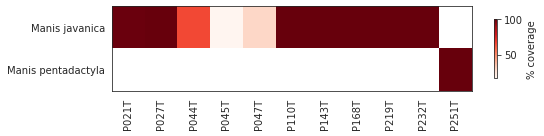

In [250]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(8,2))
#img=ax.imshow(plot_data, cmap=plt.cm.get_cmap("Reds"), interpolation="nearest", aspect='auto',norm=matplotlib.colors.LogNorm())
img=ax.imshow(plot_data, cmap=plt.cm.get_cmap("Reds"), interpolation="nearest", aspect='auto')

ax.set_xticks(list(range(len(x_codes))))
ax.set_xticklabels(x_codes,rotation=90)
ax.set_yticks(list(range(len(y_names))))
ax.set_yticklabels(y_names)

cbar=fig.colorbar(img, label='% coverage', shrink=0.7)

plt.tight_layout()
fig.savefig(PLOT_PATH+f"Mt_{PARAMS}_sample_name_{COVERAGE}pct_V2.png", bbox_inches='tight')

## Percent


In [251]:
df_all.head()

,#rname,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq,description,SRA,sample_name,total_reads,mt_reads,pct_mt
196,NC_026781.1,1,16576,170668,16575,99.9940,1459.380,35.9,17.9,Manis javanica,SRR19632900,P027T,402288132,282314,60.453254
790,NC_026781.1,1,16576,19872347,16576,100.0000,105941.000,36.1,15.0,Manis javanica,SRR19632919,P143T,1424306520,35282568,56.323414
203,NC_026781.1,1,16576,35128,10894,65.7215,316.041,35.5,20.6,Manis javanica,SRR19632962,P044T,66472232,56427,62.253886
228,NC_026781.1,1,16576,35609,4973,30.0012,316.496,35.8,29.9,Manis javanica,SRR19632960,P047T,160235136,49523,71.903964
690,NC_026781.1,1,16576,3048904,16576,100.0000,21983.600,35.9,17.9,Manis javanica,SRR19632990,P232T,786628494,5415828,56.296175


In [252]:
### filter to => N%
df_frac = df_all.loc[df_all['coverage'] >=COVERAGE]

In [253]:
df_frac

,#rname,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq,description,SRA,sample_name,total_reads,mt_reads,pct_mt
196,NC_026781.1,1,16576,170668,16575,99.9940,1459.380,35.9,17.90,Manis javanica,SRR19632900,P027T,402288132,282314,60.453254
790,NC_026781.1,1,16576,19872347,16576,100.0000,105941.000,36.1,15.00,Manis javanica,SRR19632919,P143T,1424306520,35282568,56.323414
203,NC_026781.1,1,16576,35128,10894,65.7215,316.041,35.5,20.60,Manis javanica,SRR19632962,P044T,66472232,56427,62.253886
228,NC_026781.1,1,16576,35609,4973,30.0012,316.496,35.8,29.90,Manis javanica,SRR19632960,P047T,160235136,49523,71.903964
690,NC_026781.1,1,16576,3048904,16576,100.0000,21983.600,35.9,17.90,Manis javanica,SRR19632990,P232T,786628494,5415828,56.296175
4918,NC_016008.1,1,16578,2956913,16578,100.0000,25613.400,35.9,21.10,Manis pentadactyla,SRR19632971,P251T,3557070360,5170957,57.183090
559,NC_026781.1,1,16576,2218972,16576,100.0000,16835.800,35.8,14.50,Manis javanica,SRR19633001,P219T,476656440,4070937,54.507648
597,NC_026781.1,1,16576,3615957,16576,100.0000,28712.600,36.0,22.20,Manis javanica,SRR19632949,P110T,880640316,6171357,58.592575
246,NC_026781.1,1,16576,652254,16445,99.2097,5393.000,35.9,9.35,Manis javanica,SRR19632955,P021T,1666271696,1195707,54.549651
668,NC_026781.1,1,16576,2124791,16576,100.0000,16269.900,36.2,22.00,Manis javanica,SRR19632895,P168T,906592192,3123840,68.018560


In [254]:
df_frac.description=df_frac.description.str.replace(' mitochondrion, complete genome', '')
df_frac.description=df_frac.description.str.replace(' mitochondrial DNA, complete sequence', '')
df_frac.description=df_frac.description.str.replace(' mitochondrial DNA, complete genome', '')

In [255]:
df_frac=df_frac.pivot_table(index='sample_name', columns='description', values='pct_mt')
df_frac.shape

(11, 2)

In [256]:
df_frac_pang_sus=df_frac.dropna(how='all', axis=1)

In [257]:
df_frac_pang_sus.head()

description,Manis javanica,Manis pentadactyla
sample_name,,
P021T,54.549651,NaN
P027T,60.453254,NaN
P044T,62.253886,NaN
P045T,77.781956,NaN
P047T,71.903964,NaN


In [258]:
df_frac_pang_sus=df_frac_pang_sus.T

In [261]:
df_frac_pang_sus

sample_name,P021T,P027T,P044T,P045T,P047T,P110T,P143T,P168T,P219T,P232T,P251T
description,,,,,,,,,,,
Manis javanica,54.549651,60.453254,62.253886,77.781956,71.903964,58.592575,56.323414,68.01856,54.507648,56.296175,NaN
Manis pentadactyla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.18309


In [264]:
data=df_frac_pang_sus.to_numpy()

y_labels=df_frac_pang_sus.index.tolist()
x_labels=list(df_frac_pang_sus.columns.values)
y_names=y_labels
x_codes=x_labels
plot_data = np.ma.masked_equal(data[:,:], 0)

In [266]:
df_frac_pang_sus.columns.values

array(['P021T', 'P027T', 'P044T', 'P045T', 'P047T', 'P110T', 'P143T',
       'P168T', 'P219T', 'P232T', 'P251T'], dtype=object)

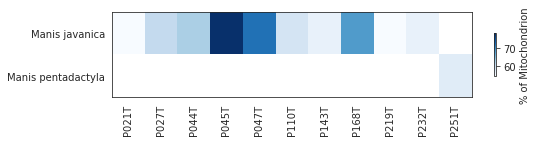

In [268]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(8,2))
#img=ax.imshow(plot_data, cmap=plt.cm.get_cmap("Blues"), interpolation="nearest", aspect='auto', \
#              norm=matplotlib.colors.LogNorm(), vmin = 10, vmax = 100)
img=ax.imshow(plot_data, cmap=plt.cm.get_cmap("Blues"), interpolation="nearest", aspect='auto')

ax.set_xticks(list(range(len(x_codes))))
ax.set_xticklabels(x_codes,rotation=90)
ax.set_yticks(list(range(len(y_names))))
ax.set_yticklabels(y_names)


cbar=fig.colorbar(img, label='% of Mitochondrion', shrink=0.5)

plt.tight_layout()
fig.savefig(PLOT_PATH+f"Mt_{PARAMS}_fraction_of_Mt_{COVERAGE}_log_V2.png", bbox_inches='tight')